### 랭그래프로 간단한 챗봇 만들기
 - 단순한 챗봇이면 랭그래프의 장점이 느껴지지 않으나 랭그래프 구조를 알아야 함

In [1]:
# 랭그래프 설치하기
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# gpt 모델 설정
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke("안녕하세요!")

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bqaj9Nk7Wz3biCLtI3aNV03108zEb', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8d4b6f92-051b-4db2-9850-745ffd0a44a5-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### 상태 정의하기

In [3]:
# 상태 클래스 정의하기
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict): # State 클래스는 TypedDict를 사용하여 딕셔너리 형태로 관리됩니다.
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
        'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]

graph_builder = StateGraph(State)

### 노드 생성하기
 - 각 노드에서 처리한 결과를 상태에서 관리하고, 각 노드를 엣지로 연결하는 그래프 형태로 표현하여 대화나 데이터 흐름을 관리합니다.

In [4]:
# 노드 생성 함수
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.

    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리.
        형식은 {"messages": [model.invoke(state["messages])]}
    """
    return {"messages": [model.invoke(state["messages"])]}

graph_builder.add_node("generate", generate)

### 엣지 설정하기

In [5]:
# graph 선언하기
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

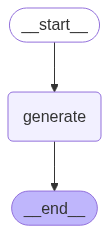

In [6]:
# 그래프 도식화하기 (그림으로 보기)
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [7]:
# messages의 리스트에 문장 추가
response = graph.invoke({"messages": ["안녕하세요! 저는 이성용입니다."]})

print(type(response))
response

<class 'langgraph.pregel.io.AddableValuesDict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 이성용입니다.', additional_kwargs={}, response_metadata={}, id='379cd1b5-d198-4e66-aeaa-e75305a5f262'),
  AIMessage(content='안녕하세요, 이성용님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 16, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqajBFX7DYNAmaxxy4TmxrEe3rJbU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4082a07e-355d-4c8a-82e0-4e35b78e4dc5-0', usage_metadata={'input_tokens': 16, 'output_tokens': 15, 'total_tokens': 31, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [8]:
# 이전 대화 내용에 새 메시지 추가하기
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)

{'messages': [HumanMessage(content='안녕하세요! 저는 이성용입니다.', additional_kwargs={}, response_metadata={}, id='379cd1b5-d198-4e66-aeaa-e75305a5f262'),
  AIMessage(content='안녕하세요, 이성용님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 16, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqajBFX7DYNAmaxxy4TmxrEe3rJbU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4082a07e-355d-4c8a-82e0-4e35b78e4dc5-0', usage_metadata={'input_tokens': 16, 'output_tokens': 15, 'total_tokens': 31, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='제 이름을

In [12]:
# 스트림 방식으로 출력하기
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려 줘.")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본의 관계는 역사적으로 매우 복잡하고, 여러 갈등과 협력이 얽혀 있는 성격을 띠고 있습니다. 두 나라의 관계는 역사적, 정치적, 경제적, 문화적 요소들이 서로 얽혀 있으며, 다음은 그 주요 측면을 정리한 것입니다.

### 역사적 배경
1. **일제강점기**: 1910년부터 1945년까지 한국은 일본의 식민지였습니다. 이 시기 동안 한국은 일본의 다양한 억압과 착취를 경험하게 되었고, 이로 인해 양국 간의 감정이 매우 좋지 않게 형성되었습니다. 문화와 언어의 억압, 강제 노동, 위안부 문제 등이 그 대표적인 예입니다.

2. **제2차 세계대전 이후**: 1945년 일본의 패전 이후, 한국은 1948년에 대한민국(남한)과 조선민주주의인민공화국(북한)으로 분단되었습니다. 이 시기 일본은 한국과의 관계 회복을 위해 노력하지만, 과거의 식민지 경험이 장애물이 됩니다.

### 정치적 측면
1. **한일 조약**: 1965년, 한국과 일본은 기본 조약을 체결하고, 외교 관계를 정상화했습니다. 이 조약은 일본의 경제 지원과 한국의 노동력 제공에 관한 내용을 포함하고 있습니다. 그러나 역사 문제와 관련된 논란이 여전히 존재합니다.

2. **영토 문제**: 독도(일본에서는 다케시마라고 부름)는 두 나라 간의 영토 갈등이 있는 지역입니다. 이 문제로 인해 양국의 외교적 긴장이 종종 고조됩니다.

3. **위안부 문제**: 일본 제국이 전쟁 중 강제로 성 착취한 여성들을 '위안부'라 부르며, 이 문제로 인해 한국과 일본 간의 갈등은 계속되고 있습니다. 일본 정부의 공식 사과와 배상 문제는 여전히 해결되지 않은 주요 쟁점 중 하나입니다.

### 경제적 관계
1. **무역**: 한국과 일본은 서로 중대한 경제 파트너입니다. 일본은 한국의 주요 수입국 중 하나이며, 한국 역시 일본에 제품을 수출하고 있습니다. 그러나 정치적 갈등이 경제 관계에 부정적인 영향을 미칠 때도 있습니다.

2. **기술 협력**: 두 국가는 기술 및 산업 분야에서도 협력하고 있으며, 특히 반도